In [1]:
#Let us import all the necessary libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise import SVD, Dataset, Reader, KNNWithMeans

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics) ( 13 Marks)

In [2]:
#Load the dataset
df = pd.read_csv('Electronic_dataset.csv')

In [3]:
#Looking at the top 5 rows of the dataset
df.head(5)

,user_id,prod_id,ratings,timestamp
0,A3L1GVWVJKWZZS,B0058UUR6E,5.0,1364774400
1,A08831071BVKZMKNCPI5S,B009ID0VVS,5.0,1357257600
2,A1SINU2I4IOPNU,B000GBO9IM,4.0,1358121600
3,A3P3P31EEOX2BD,B00CDCIOHO,3.0,1404950400
4,A3DBLJ3MPBJQMN,B000MS3VGA,5.0,1294444800


User id (user_id) looks like unique alphanumeric code assigned to each user similar to product id(prod_id) while ratings is an numeric code provided to each product ranging from 1 to 5.As quoted in earlier description we can remove the column named timestamp.

In [4]:
#Showing the shape of the dataframe
df.shape

(500000, 4)

In [5]:
#Looking at the number of unique values in user_id field
df['user_id'].nunique()

448368

In [6]:
#Looking at the number of unique values in prod_id field
df['prod_id'].nunique()

130138

In [7]:
#Chekingthe info about all atributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    500000 non-null  object 
 1   prod_id    500000 non-null  object 
 2   ratings    500000 non-null  float64
 3   timestamp  500000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 15.3+ MB


In [8]:
#Checking the number of duplicates in each row(False means none are present)
df.duplicated().value_counts()

False    500000
dtype: int64

In [9]:
#dropping timestamp column, since it's of no significance 
df = df.drop(labels = "timestamp", axis = 1)

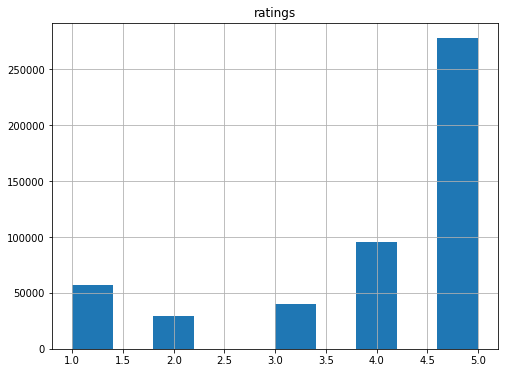

In [10]:
#Building a histogram for dataframe(for ratings as that is only numeric column)
df.hist(figsize=(8,6), xlabelsize = 10);

Looking at the histogram it seems most of the ratings are 5 out of 5,With lest of them rated as 2.

In [11]:
#Checking the transpose of descirption
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,500000.0,4.013172,1.379996,1.0,3.0,5.0,5.0,5.0


We see a lot of attributes in given dataset hence we need to prune the dataset and one observation is that we have many users who have given one or 2 ratings for each product which are of ver less significance hence for future computation we have to consider the users who have given more than 5 ratings.Hence filtering users with minimum 5 ratings. 

In [12]:
#Using the counter library for getting counts
from collections import Counter
counts = Counter(df.user_id)
df_popular = df[df.user_id.isin([key for key in counts if counts[key] > 5])]
df_popular[df_popular.user_id.isin([key for key in counts if counts[key] > 5])].count()

user_id    5912
prod_id    5912
ratings    5912
dtype: int64

now we see number of records trimmed down to 5912

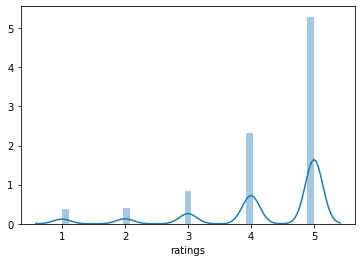

In [13]:
#Checking the distribution plot
sns.distplot(df_popular['ratings'])
plt.show()

The distribuion looks skewed due to more number of 5 star ratings

# 2. Build Popularity Recommender model. ( 10 marks)

We are taking the previous dataset(pruned) and grouping them by Product id based on mean ratings and sorting
them in descending value of top 10

In [14]:
df_popular.groupby('prod_id').mean()['ratings'].sort_values(ascending=False).head(10)

prod_id
B00L26YDA4    5.0
B0030BJEUS    5.0
B0032FOJOS    5.0
B0032ANC8M    5.0
B0031U1AT6    5.0
B0031RG2JC    5.0
B0031AQ302    5.0
B00310V8IY    5.0
B0030O0Q2U    5.0
B0030MITDK    5.0
Name: ratings, dtype: float64

In [15]:
df_popular

,user_id,prod_id,ratings
26,A2HX3D3MPPASNS,B004I3VZM2,4.0
214,AZNUHQSHZHSUE,B000FJEYZI,1.0
264,A1YEPFLLH42OU1,B00E3W15P0,5.0
286,A2GYV87WW0DMSN,B0009Y7APU,5.0
413,A10Y058K7B96C6,B005HSG3VK,5.0
...,...,...,...
499755,ADKZOXAOV8EXD,B0076BNKU8,5.0
499783,A9Y5O2R4D6EH5,B006NNWZSI,5.0
499873,AR74YY08IP2WE,B0088CJT4U,5.0
499916,A18S2VGUH9SCV5,B00064C53K,5.0


In [16]:
#Below are the most and least liked item
print("Most Liked: ",df_popular.groupby('prod_id')['ratings'].mean().sort_values(ascending=False).head(1))
print("Least Liked: ",df_popular.groupby('prod_id')['ratings'].mean().sort_values(ascending=True).head(1))

Most Liked:  prod_id
B00L26YDA4    5.0
Name: ratings, dtype: float64
Least Liked:  prod_id
1400501466    1.0
Name: ratings, dtype: float64


In [17]:
df_popular.groupby('user_id').mean()['ratings'].sort_values(ascending=False).head(10)

user_id
A3GVXKCTFN3YDN    5.0
A1Q9NE8OY1XD5J    5.0
A1Z4YY7V0KXPED    5.0
A3CEUT263RNUDO    5.0
A3CVC8TCHFFDK8    5.0
A3D0UM4ZD2CMAW    5.0
A3GQY0TFRG0MPZ    5.0
A3HR0ZZOFKQ97N    5.0
A3HSDV9Y0TV5Z2    5.0
A3LDFTSXU3UPBO    5.0
Name: ratings, dtype: float64

In [18]:
#Finding the highest average rated product.
ratings_mean_count = pd.DataFrame(df_popular.groupby('prod_id')['ratings'].mean())

In [19]:
ratings_mean_count['ratings'].sort_values(ascending=False).head(10)

prod_id
B00L26YDA4    5.0
B0030BJEUS    5.0
B0032FOJOS    5.0
B0032ANC8M    5.0
B0031U1AT6    5.0
B0031RG2JC    5.0
B0031AQ302    5.0
B00310V8IY    5.0
B0030O0Q2U    5.0
B0030MITDK    5.0
Name: ratings, dtype: float64

Above products are the most popular products

In [20]:
# Creating a column in the dataframse to records the number of times a product is rated.
ratings_mean_count['rating_counts'] = pd.DataFrame(df_popular.groupby('prod_id')['ratings'].count())

In [21]:
df_pop=ratings_mean_count.sort_values(by=['ratings','rating_counts'],ascending=False)

In [22]:
df_pop.head(10)

,ratings,rating_counts
prod_id,,
B003ES5ZUU,5.0,13
B000QUUFRW,5.0,6
B00829THVO,5.0,5
B00005T3G0,5.0,4
B000S5Q9CA,5.0,4
B0013DXVYK,5.0,4
B001XURP7W,5.0,4
B00267S7XW,5.0,4
B002RCNX8K,5.0,4


In [23]:
basic_poplurity_model = df_pop.sort_values(by=['rating_counts'], ascending=False)
basic_poplurity_model.head(10)

,ratings,rating_counts
prod_id,,
B003ES5ZUU,5.000000,13
B007WTAJTO,4.923077,13
B0088CJT4U,4.333333,9
B005FYNSPK,4.888889,9
B0079UAT0A,4.857143,7
B00829TIEK,4.571429,7
B001TH7GSW,4.857143,7
B002SZEOLG,3.571429,7
B00829THK0,4.428571,7


Above is the top 10 product Ids sorted based on the ratings and times rated.

In [24]:
#Check the shape of new dataframe in which rows must be equal to df_popular['productId'].nunique().
ratings_mean_count.shape

(4971, 2)

As the name suggests Popularity based recommendation system works with the trend. It basically uses the items that are highly rated and with most of the ratings.


# 3. Split the data randomly into a train and test dataset. ( For example, split it in 70/30 ratio) ( 2 marks)

In [25]:
reader = Reader(rating_scale=(1,5))

In [26]:
data = Dataset.load_from_df(df_popular[['user_id', 'prod_id', 'ratings']], reader)

In [27]:
#We are giving a random state of 123 as it was used in classroom example.
trainset, testset = train_test_split(data, test_size=0.30, random_state = 123)

# 4. Build Collaborative Filtering model. ( 10 marks)

In [28]:
Countu=df_popular.groupby('user_id')['ratings'].count()

In [29]:
print("The max ratings by a user is {} with a median of {}".format(Countu.max(),Countu.median()))


The max ratings by a user is 36 with a median of 7.0


In [30]:
Countp=df_popular.groupby('prod_id')['ratings'].count()

In [31]:
print("The max ratings for a Product is {} with a median of {}".format(Countp.max(),Countp.median()))

The max ratings for a Product is 13 with a median of 1.0


In [32]:
algo = SVD(n_factors=50,biased=False)

In [33]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
pred = algo.test(testset)

In [34]:
#Checking the output prediction of testset based on traindata
print(pd.DataFrame(pred))

                 uid         iid  r_ui       est  \
0     A3IY316DRNF5F2  B00AQ64KM2   5.0  4.233929   
1     A2TKWMX4563NR6  B003ZM17RK   5.0  4.233929   
2      ACJT8MUC0LRF0  B003CJTQJW   5.0  1.000000   
3      AN1EG21Q0IYPI  B004OCXGAG   5.0  4.233929   
4     A18I3164IW4H23  B003ZFZSBI   5.0  4.233929   
...              ...         ...   ...       ...   
1769  A1V4VVBQBFXRHC  B0000AE6G9   1.0  4.233929   
1770  A30X750M8V1XXW  B0000BZL1P   5.0  1.000000   
1771  A225G2TFM76GYX  B000X3OOQU   4.0  4.233929   
1772  A1PN2U0AWXGVML  B000069AT6   5.0  4.233929   
1773   AKSQNMIKOU01H  B005ZLOW8K   4.0  4.233929   

                                                details  
0     {'was_impossible': True, 'reason': 'User and i...  
1     {'was_impossible': True, 'reason': 'User and i...  
2                             {'was_impossible': False}  
3     {'was_impossible': True, 'reason': 'User and i...  
4     {'was_impossible': True, 'reason': 'User and i...  
...                        

Collaborative filtering can also be done in 2 ways 
1.User-User
2.Product-Product
one is filtering done based on grouping of user id while the other is filtering done based on product id

In [ ]:
# User based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

# run the trained model against the testset
test_pred_User = algo.test(testset)
test_pred_User

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# Product based collaborative filtering
algo_Prod = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo_Prod.fit(trainset)

# run the trained model against the testset
test_pred_Prod = algo_Prod.test(testset)
test_pred_Prod

# 5. Evaluate the above model. (Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models. ( 5 marks)

In [ ]:
# Then compute RMSE,MAE and FCP(Ratio of concordant pairs used in classification models)
print("The RMSE is {},MAE is {} and FCP is {}".format(accuracy.rmse(pred),accuracy.mae(pred),accuracy.fcp(pred)))

In [ ]:
# Then compute RMSE,MAE and FCP(Ratio of concordant pairs used in classification models)
print("The RMSE is {},MAE is {} and FCP is {}".format(accuracy.rmse(test_pred_User),accuracy.mae(test_pred_User),accuracy.fcp(test_pred_User)))

In [ ]:
# Then compute RMSE,MAE and FCP(Ratio of concordant pairs used in classification models)
print("The RMSE is {},MAE is {} and FCP is {}".format(accuracy.rmse(test_pred_Prod),accuracy.mae(test_pred_Prod),accuracy.fcp(test_pred_Prod)))

In [ ]:
predictions=pd.DataFrame(pred)

In [ ]:
predictions.head()

In [42]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNWithMeans(k=20)]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.039295,0.728784,0.020605
KNNWithMeans,1.077050,0.055012,0.025407


Above we compare the conventional SVD used for collaborative filtering taking more time than KNNwith means,Lower RMSE shows a better fit hence SVD seems to have a lower RMSE and test time.


# 6. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products. ( 10 marks)

In [43]:
from collections import defaultdict

def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, r_ui, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [44]:
predictions.head(2)

,uid,iid,r_ui,est,details
0,A3IY316DRNF5F2,B00AQ64KM2,5.0,4.233929,"{'was_impossible': True, 'reason': 'User and i..."
1,A2TKWMX4563NR6,B003ZM17RK,5.0,4.233929,"{'was_impossible': True, 'reason': 'User and i..."


In [45]:
top_n = get_top_n(pred, n=5)

In [46]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A3IY316DRNF5F2 ['B00AQ64KM2', 'B004IAPSAA', 'B000NDBRKG', 'B009SYZ8OC']
A2TKWMX4563NR6 ['B003ZM17RK', 'B001NPEBGU', 'B000QDTJDK']
ACJT8MUC0LRF0 ['B00GXJHDHA', 'B003CJTQJW']
AN1EG21Q0IYPI ['B004OCXGAG']
A18I3164IW4H23 ['B003ZFZSBI', 'B000O9T5IA', 'B000V1IFR8']
A3QWNQ2WA7QZYJ ['B00006HYKM', 'B0009HHZ1Q']
A2R27MAG4MAQN4 ['B008M5108Q', 'B00BEW8MVC', 'B0036ORCLW']
A231WM2Z2JL0U3 ['B00008SB1D', 'B00004SD9Q', 'B00005OMZN', 'B000066JQU', 'B00005AC8J']
AYUF7YETYOLNX ['B008RW6QHY', 'B0084Y9V54']
A13BX9O5UDBILC ['B002SB8RPO', 'B004N7W4Q4', 'B002SQK2F2', 'B00267S7XW']
A1A6UYFNC1L304 ['B004DUMQVY', 'B0071NWYP8']
A2S26YGSVXBCFL ['B0031RG2AG']
A3CG93783LP0FO ['B003XE3X8Q', 'B00EXK14S0', 'B005HY4U5A', 'B002W7RHOG', 'B000JMJWV2']
A1QQA7Y92L4F9R ['B001KX8VES', 'B004D2B6YA', 'B001IT4BWA']
A2YNF8D4ADUPD9 ['B000I54FFS', 'B000BFYCUS', 'B001HABRKE']
A1ZTR0FR5AW9B4 ['B005Z43V9S', 'B009D79VH4', 'B001J6N11E']
A1BITE87QKYF64 ['B001UAGSJQ', 'B00099C2M6', 'B000Y0KQEG']
A1EH2S92FHWZRP ['B0029U2YPS', 'B0090Z3QD4']
A

A25PKF8V3Q4IOL ['B00CY9PWKI', 'B00CHH0JF0']
A32O5FZH994CNY ['B00DBCJKPK', 'B000LFZ6OE']
A2WW57XX2UVLM6 ['B002G1YPH0', 'B00E87E1OM', 'B001M4HXB2']
ARQ4HTA950LU9 ['B0040RWN0O']
AOKS5JEGN6G ['B00APV9X16', 'B000VWKSFE', 'B0025VKUQG']
A17W0GMB0YY83M ['B005FYNSPK']
A28N2AWOVO2PB ['B00DTPYQBM', 'B003ES547O', 'B0076POAI0', 'B0088CJT4U']
A2VQLV2GUC4H8J ['B0039SM0AS', 'B000A6QVE8', 'B003SALO6S']
A370XYLIZCSK1Y ['B002Q0WN48', 'B00BBD7NFU']
A8I7ZSX0J2BUA ['B002K42W4Q', 'B003Y54NPQ', 'B002WE6D44']
A3NGABXDIB0POU ['B0058UUR6E']
A35W3JQYP0M655 ['B00G500AE0', 'B0071CVTAK', 'B00E362W9O']
A1435P5AMCPB3X ['B0001WOSJQ', 'B000GIQR0S']
A21INUA35HX4XQ ['B0053ORUS8']
A3NCIN6TNL0MGA ['B0014T7W8Y']
A6VXZ1EEPRTLV ['B002VFFA5M', 'B001LJG102', 'B005IA843W']
AX05DBU8IRUWY ['B000J1H4VI', 'B00C57P2BI', 'B00A1EQ950']
A37QUQPYFMR9Y9 ['B000OL3QTW']
ANYC38I00IRVK ['B0057UAB2K', 'B003MX4D0U']
A19QKBWRI072AC ['B00CSFCYFY']
AR1T36GLLAFFX ['B0065VKQ34', 'B0017UCTX8']
A14OQ67LM79KW3 ['B002MCZJ78']
A3F9CMU8KNAY1M ['B006WHPQCC'

In above results we are looking at top 5 predictions for each user(some of users may have less than 5 predictions)

# 7. Summarise your insights. ( 10 marks)

The dataset provided has 500000 rows and 4 columns with user_id representing unique user notation similar to prod_id which represents unique product code. Both of them being categorical the only numeric column is rating representing how a user has rated a particular product between 1 to 5.

There is a column named timestamp which was termed insignificant hence dropped.

We had to reduce the number of records by filtering out users less than 5 ratings given hence the number of records came down to 5912 rows with 3 columns(user_id,prod_id and ratings).

We ran a popularity based model under which top product with best rating(with significant number of ratings) were derived these ratings are supposed to be recommended to new users or users who aren't logged in. The popularity bases items are soley based on the ratings count or frequency of a product(with or without weighted ratings). There is no way to know the user habits.Also, the products with very few ratings will never make this list until a hybrid recommendation system is used such as popularity with random. This approach can be weighted to make sure, random recommedations are for those products which have very low ratings count but high rating values.

However, on running collaborative filtering model using Singular Value Decomposition (SVD) and also running K Nearest Neighbor(KNN) we found the SVD more effective due to lower MAE and RMSE.We have alse run the KNN model in User-User(Grouping based on User ID) and Product-Product/Item_Item(Product ID based) to achieve predictions.In the end we derived top 5 product recommendations for each user and a probable rating that the user might provide to the recommended product. There are limitations with collaborative filtering with a straightforward implementation, it is obeserved that the recommendations tend to be already popular, and the items from the long tail section might get ignored. User user-Scalability is an issue as KNN needs to compute nearest neighbors for both items and users.So, large data are slow down KNN by a great extent.

Hybrid recommedation system with Collaborative and content-based filtering might help get over the classic problems of collaborative filtering such as cold start ,etc.

For Collaborative filtering, SVD outperforms KNNWithMeans with better RMSE and MAE.

Conclusion:-
The recommendations obtained using the above techniques can be suggested to the users for better sales